In [284]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [285]:
year=2019
quarter=3

algorithm="a_star"
moneyMultiplier=0

In [286]:
dropColumns=["tbl","citymarketid_1","citymarketid_2","airportid_1","airportid_2","tbl1apk"]
data=pd.read_csv('US Airline Flight Routes and Fares 1993-2024.csv').drop(columns=dropColumns).dropna().reset_index(drop=True)
data=data.loc[(data["city1"]!="Key West, FL") & (data["city2"]!="Key West, FL") & (data["city1"]!="Tulsa, OK") & (data["city2"]!="Tulsa, OK"),:].reset_index(drop=True)
data=data.loc[(data["Year"]==year) & (data["quarter"]==quarter),:].reset_index(drop=True)
data.head()

C:\Users\alt_user\AppData\Local\Temp\ipykernel_12812\3815099057.py:2: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv('US Airline Flight Routes and Fares 1993-2024.csv').drop(columns=dropColumns).dropna().reset_index(drop=True)


,Year,quarter,city1,city2,airport_1,airport_2,nsmiles,passengers,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,Geocoded_City1,Geocoded_City2
0,2019,3,"Albuquerque, NM","Boston, MA (Metropolitan Area)",ABQ,BOS,1974,191,301.58,WN,0.3523,269.51,WN,0.3523,269.51,"(35.084248, -106.649241)","(42.358894, -71.056742)"
1,2019,3,"Albuquerque, NM","Los Angeles, CA (Metropolitan Area)",ABQ,BUR,677,62,197.14,WN,0.8697,191.40,WN,0.8697,191.40,"(35.084248, -106.649241)","(34.052238, -118.243344)"
2,2019,3,"Albuquerque, NM","Washington, DC (Metropolitan Area)",ABQ,BWI,1670,306,291.79,WN,0.8598,294.65,AA,0.0795,258.14,"(35.084248, -106.649241)","(38.892062, -77.019912)"
3,2019,3,"Albuquerque, NM","Dallas/Fort Worth, TX",ABQ,DAL,580,317,218.01,WN,0.9997,218.03,WN,0.9997,218.03,"(35.084248, -106.649241)","(40.11086, -77.035636)"
4,2019,3,"Albuquerque, NM","Washington, DC (Metropolitan Area)",ABQ,DCA,1670,235,310.64,WN,0.4081,279.22,WN,0.4081,279.22,"(35.084248, -106.649241)","(38.892062, -77.019912)"


In [287]:
data=data.sample(50, random_state=42)

In [288]:
G = nx.Graph()

dataNp=data["city1"].to_numpy()
posNp=data["Geocoded_City1"].to_numpy()
for airport, pos in zip(dataNp,posNp):
    pos=pos.split("(")[-1][:-1]
    latitude,longtitude=pos.split(",")
    pos=(float(latitude),float(longtitude))
    G.add_node(airport,pos=pos)


dataNp=data["city2"].to_numpy()
posNp=data["Geocoded_City2"].to_numpy()
for airport, pos in zip(dataNp,posNp):
    pos=pos.split("(")[-1][:-1]
    latitude,longtitude=pos.split(",")
    pos=(float(latitude),float(longtitude))
    G.add_node(airport,pos=pos)

In [289]:
import heapq
from math import radians, sin, cos, sqrt, asin

def a_star(graph, start, goal, h):
    dist = {node: float('inf') for node in graph}
    dist[start] = 0

    prev = {node: None for node in graph}

    # Priority queue stores (f_score, node), where f_score = dist[node] + h(node, goal)
    pq = [(dist[start] + h(start, goal), start)]
    previousVisits = set()
    # previousVisits.add(start)
    while pq:
        # print("pq: ", pq)
        f_score, current_node = heapq.heappop(pq)
        # print("yes")
        if(current_node in previousVisits):
            continue
        # If we've reached the goal, we can stop
        if current_node == goal:
            break

        # If the f_score is out of date, skip
        if f_score > dist[current_node] + h(current_node, goal):
            continue

        # For each neighbor, check if we have found a better path
        previousVisits.add(current_node)
        graph_neighbors = graph.edges(current_node)
        # print(graph_neighbors)
        for itself, neighbor in graph_neighbors:
            
            weight = G.edges[(itself, neighbor)]["weight"] + moneyMultiplier * G.edges[(itself, neighbor)]["price"]
            tentative_g_score = dist[current_node] + weight
            # print(f"tentative_g_score: {tentative_g_score} dist[neighbor]: {dist[neighbor]}")
            if tentative_g_score < dist[neighbor]:
                dist[neighbor] = tentative_g_score
                prev[neighbor] = current_node
                # Recompute f-score = g-score + heuristic
                heapq.heappush(pq, (dist[neighbor] + h(neighbor, goal), neighbor))

    return dist, prev

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    return R * c

def heuristic(u, v):
    lat1, lon1 = G.nodes[u]['pos']
    lat2, lon2 = G.nodes[v]['pos']
    distance=haversine(lat1,lon1,lat2,lon2)
    return distance



def dijkstra(graph, start):
    dist = {node: float('inf') for node in graph}
    dist[start] = 0

    # Keep track of the path
    prev = {node: None for node in graph}
    pq = [(0, start)]

    while pq:
        current_dist, current_node = heapq.heappop(pq)

        # If this distance is outdated (i.e., we already found a better path), skip
        if current_dist > dist[current_node]:
            continue
        
        #Dijkstra’s doesn't need a goal parameter because it calculates the shortest path to all nodes

        # Explore neighbors
        graph_neighbors = graph.edges(current_node)
        # print(graph_neighbors)
        for itself, neighbor in graph_neighbors:

            weight = G.edges[(itself, neighbor)]["weight"] + moneyMultiplier * G.edges[(itself, neighbor)]["price"]
            new_dist = dist[current_node] + weight
            if new_dist < dist[neighbor]:
                dist[neighbor] = new_dist
                prev[neighbor] = current_node
                heapq.heappush(pq, (new_dist, neighbor))

    return dist, prev

In [290]:
flights=[]

dfNp=data.to_numpy()

for flight in dfNp:
    origin, dest, distance, fare, originPos, destPos = flight[2], flight[3], flight[6], flight[8], flight[-2], flight[-1]
    flights.append((origin,dest,distance,fare,originPos,destPos))
    G.add_edge(origin,dest,weight=distance,price=fare)

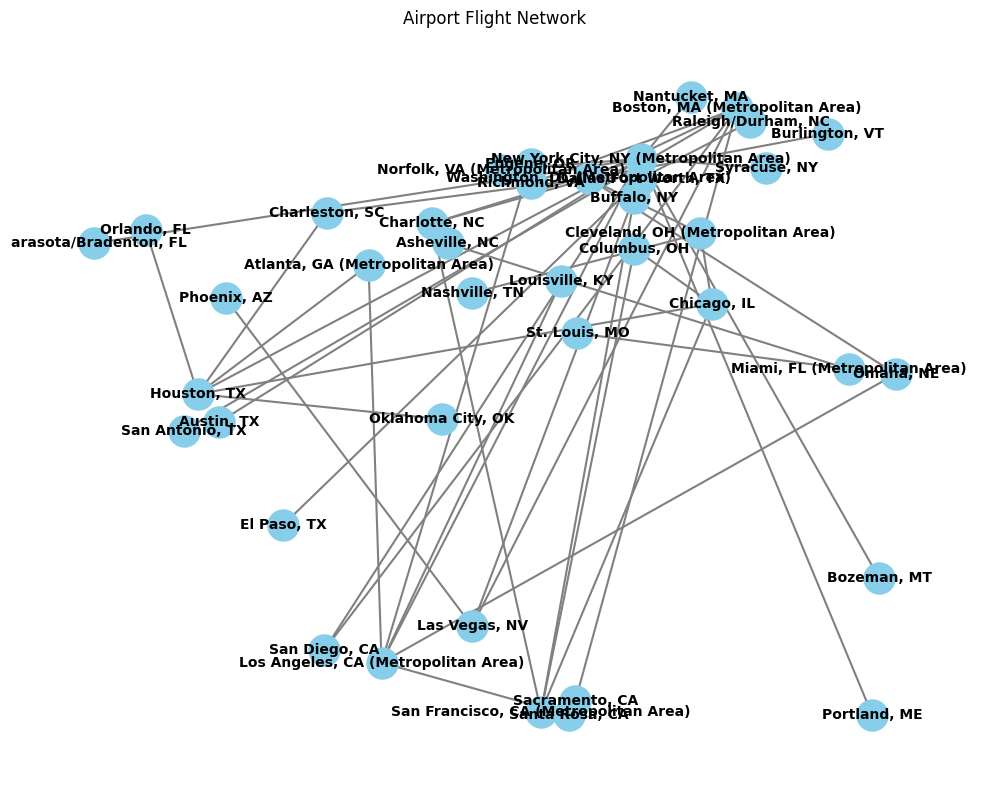

In [291]:
plt.figure(figsize=(10, 8)),
# pos = nx.spring_layout(G, seed=42)
pos = nx.get_node_attributes(G, 'pos')
nx.draw_networkx_nodes(G, pos, node_size=500, node_color="skyblue")
nx.draw_networkx_edges(G, pos, width=1.5, edge_color="gray")
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

# Add edge labels (distance)
edge_labels = nx.get_edge_attributes(G, "distance")
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")

plt.title("Airport Flight Network")
plt.axis("off")
# plt.show()
plt.tight_layout(); 

In [292]:

if(input("Do you want random start and end cities? (y/n) ")=="y"):
    start= data.sample(1)["city1"].values[0]
    end= data.sample(1)["city2"].values[0]

else:
    start = 'Atlanta, GA (Metropolitan Area)'
    end = 'Eugene, OR'
print("Start: ",start," End: ",end)

# start = 'Atlanta, GA (Metropolitan Area)'
# end = 'Syracuse, NY'
# Start:  Atlanta, GA (Metropolitan Area)  End:  Syracuse, NY

Start:  Boston, MA (Metropolitan Area)  End:  San Francisco, CA (Metropolitan Area)


In [293]:
print("Dijkstra") 
distances, preds = dijkstra(G, start)
if(distances[end]==float('inf')):
    print("No path found")
else:
    path = []
    node = end
    while node is not None:
        path.append(node)
        node = preds[node]
    path.reverse()
    print(f"Optimal Flight Path: {path}, Distance with heuristic: {distances[end]} km")


# #####################
print("A*")
distances, preds = a_star(G, start, end, heuristic)

path = []
node = end
while node is not None:
    path.append(node)
    node = preds[node]
path.reverse()
# path = nx.astar_path(G, start, end, heuristic=heuristic, weight='weight')
print(f"Optimal Flight Path: {path}, Distance with heuristic: {distances[end]} km")

Dijkstra
Optimal Flight Path: ['Boston, MA (Metropolitan Area)', 'Washington, DC (Metropolitan Area)', 'Cleveland, OH (Metropolitan Area)', 'Chicago, IL', 'San Francisco, CA (Metropolitan Area)'], Distance with heuristic: 2930.0 km
A*
Optimal Flight Path: ['Boston, MA (Metropolitan Area)', 'Washington, DC (Metropolitan Area)', 'Cleveland, OH (Metropolitan Area)', 'Chicago, IL', 'San Francisco, CA (Metropolitan Area)'], Distance with heuristic: 2930.0 km


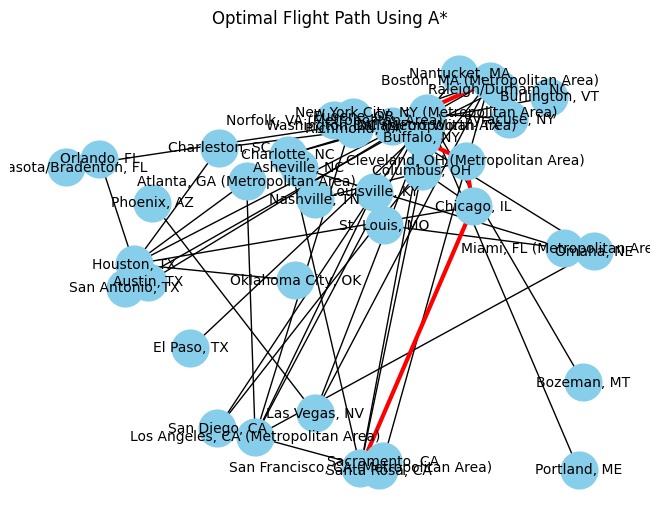

In [294]:
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=10)

# Highlight the optimal path
path_edges = list(zip(path, path[1:]))
nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=3)

plt.title("Optimal Flight Path Using A*")
plt.show(); 